# **XGBoost for Predicting Interview Offers and Matched Program Rank**

In [1]:
# Importing required packages
import os
import glob
import pandas as pd
import numpy as np
import pickle
from itertools import islice
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Printing the working directory
os.getcwd()

'c:\\Users\\toofa\\OneDrive - Baylor College of Medicine\\APSA\\2024-07-29_Texas-STAR'

### Reading in cleaning the Texas STAR dataset

In [3]:
# Importing TexasSTAR
df = pd.read_excel("tables/df_clean.xlsx")
print(df.shape)

# Importing doximity residency match ranks
dox = pd.read_excel("tables/reputation_doximity_ranks.xlsx")
print(dox.shape)

(40039, 62)
(34731, 12)


In [333]:
# Merging doximity ranks with the rest of the data
degree_list = ["MD", "MD-PhD", "MD-MPH", "MD-MBA", "MD-MSc"]
df_clean = df[df["degrees"].isin(degree_list)]
dox_clean = dox[dox["degree"].isin(degree_list)]
dox_clean = dox_clean[dox_clean["reputation_rank_mean"].notna()]  #filtering for ranked schools only
dox_clean = dox_clean.drop(['specialty', 'degree', 'application_count', 'interviews_yes',
       'matched', 'geographic_connection_yes', 'geo_preference_eras_yes',
       'away_rotation_yes', 'signaled_program_yes', 'program_size_mean'], axis=1)
df_clean = df_clean[df_clean["STAR.ID"].isin(dox_clean["STAR.ID"])]
df_clean = df_clean.merge(dox_clean, on="STAR.ID")

## **XGBoost for predicting program rank reputation**

In [335]:
# Filtering for predictor columns
cols_to_keep = ['Public_School', "IvyP", 'step1_centered', 'step2_centered', "X..Honored.Clerkships", "Honors.A.This.Specialty", "AOA.Sigma", 'GHHS',
                "Couples.Match", "X..Research.Experiences", "X..Abstracts..Pres..Posters", "X..Peer.Rev.Publications", "X..Volunteer.Experiences", 
                "X..Leadership.Positions", 'Required.to.Remediate', "reputation_rank_mean"]  #"degrees", "X..Interviews.Attended" 

# Train test split
df_clean2 = df_clean.set_index("STAR.ID")
df_clean2 = df_clean2[cols_to_keep]
X = df_clean2.drop(columns="reputation_rank_mean")
y = df_clean2["reputation_rank_mean"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [337]:
# Setting up the pipeline for training
categorical_cols = ['Public_School', 'IvyP', 'Honors.A.This.Specialty', 'AOA.Sigma', 'GHHS', 'Couples.Match', 'Required.to.Remediate']
numeric_cols = ['step1_centered', 'step2_centered', "X..Honored.Clerkships", "X..Research.Experiences", "X..Abstracts..Pres..Posters", "X..Peer.Rev.Publications", "X..Volunteer.Experiences", "X..Leadership.Positions"]

# Preprocessing for each type
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', TargetEncoder(), categorical_cols),
        ('num', MinMaxScaler(), numeric_cols)
    ]
)

# Making the pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', XGBRegressor(random_state=7))
])

print(pipe)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                                  ['Public_School', 'IvyP',
                                                   'Honors.A.This.Specialty',
                                                   'AOA.Sigma', 'GHHS',
                                                   'Couples.Match',
                                                   'Required.to.Remediate']),
                                                 ('num', MinMaxScaler(),
                                                  ['step1_centered',
                                                   'step2_centered',
                                                   'X..Honored.Clerkships',
                                                   'X..Research.Experiences',
                                                   'X..Abstracts..Pres..Posters',
                                                   'X..Peer.Rev.Pu...
    

In [339]:
# Set up hyperparameter tuning
search_space = {
    "clf__max_depth": Integer(2, 8),
    "clf__learning_rate": Real(0.001, 1.0, prior="log-uniform"),
    "clf__subsample": Real(0.5, 1.0),
    "clf__colsample_bytree": Real(0.5, 1.0),
    "clf__colsample_bylevel": Real(0.5, 1.0),
    "clf__colsample_bynode": Real(0.5, 1.0),
    "clf__reg_alpha": Real(0.0, 10.0),
    "clf__reg_lambda": Real(0.0, 10.0),
    "clf__gamma": Real(0.0, 10.0)
}

opt = BayesSearchCV(pipe, search_space, cv=10, n_iter=20, scoring="neg_mean_squared_error", random_state=7)

In [341]:
# Training the XGBoost model 
opt.fit(X_train, y_train)

BayesSearchCV(cv=10,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('cat',
                                                                          TargetEncoder(),
                                                                          ['Public_School',
                                                                           'IvyP',
                                                                           'Honors.A.This.Specialty',
                                                                           'AOA.Sigma',
                                                                           'GHHS',
                                                                           'Couples.Match',
                                                                           'Required.to.Remediate']),
                                                                         ('num',
                                                                          MinMaxScaler(),
                                                                          ['step1_centered',
                                                                           'step2_centered',
                                                                           'X..Honored.Clerkships',
                                                                           'X..Research.Experiences',
                                                                           'X..Abstracts.....
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [343]:
# Evaluating the model
np.sqrt(np.abs(opt.best_score_))

77.21375497911079

In [345]:
np.sqrt(np.abs(opt.score(X_test, y_test)))

76.22393021573957

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

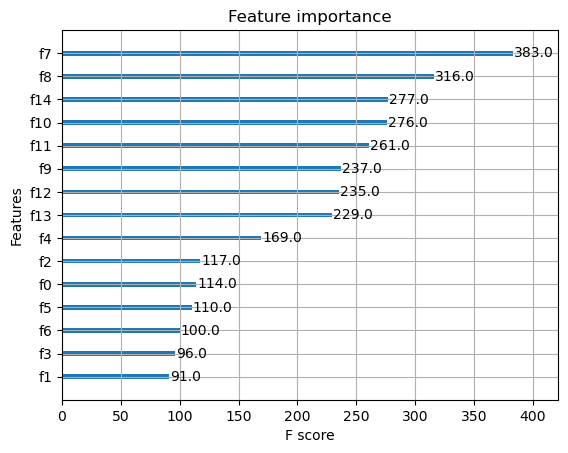

In [347]:
# Measuring feature importance
xgboost1 = opt.best_estimator_.steps[1]
xgboost2 = xgboost1[1]
plot_importance(xgboost2)

In [349]:
# Step 1: Get the regressor
xgboost_model = opt.best_estimator_.named_steps['clf']

# Step 2: Get transformed feature names from the preprocessor
preprocessor = opt.best_estimator_.named_steps['preprocessor']

# Get transformed feature names for each transformer
cat_features = preprocessor.transformers_[0][2]  # list of categorical column names
num_features = preprocessor.transformers_[1][2]  # list of numeric column names

# Combine them (TargetEncoder returns same names; MinMaxScaler does too)
all_features = cat_features + num_features

# Step 3: Extract feature importances
importances = xgboost_model.feature_importances_

# Step 4: Create DataFrame
feat_imp_df = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

display(feat_imp_df)

,feature,importance
2,Honors.A.This.Specialty,0.167505
3,AOA.Sigma,0.167081
7,step1_centered,0.115471
8,step2_centered,0.100527
6,Required.to.Remediate,0.069084
10,X..Research.Experiences,0.060180
12,X..Peer.Rev.Publications,0.057945
9,X..Honored.Clerkships,0.053035
11,X..Abstracts..Pres..Posters,0.043233
0,Public_School,0.038358


In [351]:
opt.best_params_

OrderedDict([('clf__colsample_bylevel', 1.0),
             ('clf__colsample_bynode', 0.5),
             ('clf__colsample_bytree', 0.6821798019219066),
             ('clf__gamma', 2.1333523826185945),
             ('clf__learning_rate', 0.05644652778755661),
             ('clf__max_depth', 5),
             ('clf__reg_alpha', 8.89737641989899),
             ('clf__reg_lambda', 10.0),
             ('clf__subsample', 1.0)])

## **XGBoost on individual degree paths, using the best parameters**

### **MD**

In [353]:
# Filtering for predictor columns
cols_to_keep = ['Public_School', "IvyP", 'step1_centered', 'step2_centered', "X..Honored.Clerkships", "Honors.A.This.Specialty", "AOA.Sigma", 'GHHS', 'Research.Year', 
                'Absence.Year', "Couples.Match", "X..Research.Experiences", "X..Abstracts..Pres..Posters", "X..Peer.Rev.Publications", "X..Volunteer.Experiences", "X..Leadership.Positions", 
                'Required.to.Remediate', "reputation_rank_mean"]  #"degrees", "X..Interviews.Attended" 

# Train test split
df_clean2 = df_clean.set_index("STAR.ID")
df_clean2 = df_clean2[df_clean2["degrees"]=="MD"]
df_clean2 = df_clean2[cols_to_keep]
X = df_clean2.drop(columns="reputation_rank_mean")
y = df_clean2["reputation_rank_mean"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [355]:
# Set up best params from overall test
best_params = {
    "max_depth": 5,
    "learning_rate": 0.05644652778755661,
    "subsample": 1.0,
    "colsample_bytree": 0.6821798019219066,
    "colsample_bylevel": 1.0,
    "colsample_bynode": 0.5,
    "reg_alpha": 8.89737641989899,
    "reg_lambda": 10.0,
    "gamma": 2.1333523826185945,
    "random_state": 7
}

# Making the pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', XGBRegressor(**best_params))
])
print(pipe)

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                                  ['Public_School', 'IvyP',
                                                   'Honors.A.This.Specialty',
                                                   'AOA.Sigma', 'GHHS',
                                                   'Couples.Match',
                                                   'Required.to.Remediate']),
                                                 ('num', MinMaxScaler(),
                                                  ['step1_centered',
                                                   'step2_centered',
                                                   'X..Honored.Clerkships',
                                                   'X..Research.Experiences',
                                                   'X..Abstracts..Pres..Posters',
                                                   'X..Peer.Rev.Pu...
    

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                                  ['Public_School', 'IvyP',
                                                   'Honors.A.This.Specialty',
                                                   'AOA.Sigma', 'GHHS',
                                                   'Couples.Match',
                                                   'Required.to.Remediate']),
                                                 ('num', MinMaxScaler(),
                                                  ['step1_centered',
                                                   'step2_centered',
                                                   'X..Honored.Clerkships',
                                                   'X..Research.Experiences',
                                                   'X..Abstracts..Pres..Posters',
                                                   'X..Peer.Rev.Pu...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.05644652778755661, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=7, ...))])

In [357]:
# Function to get feature importances dataframe
def feat_importances(model, degree):
    
    # Step 1: Get the regressor
    xgboost_model = model.named_steps['clf']
    
    # Step 2: Get transformed feature names from the preprocessor
    preprocessor = model.named_steps['preprocessor']
    
    # Get transformed feature names for each transformer
    cat_features = preprocessor.transformers_[0][2]  # list of categorical column names
    num_features = preprocessor.transformers_[1][2]  # list of numeric column names
    
    # Combine them (TargetEncoder returns same names; MinMaxScaler does too)
    all_features = cat_features + num_features
    
    # Step 3: Extract feature importances
    importances = xgboost_model.feature_importances_
    
    # Step 4: Create DataFrame
    feat_imp_df = pd.DataFrame({
        'feature': all_features,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    feat_imp_df["degree"] = degree

    # Step 5: returning the dataframe
    return feat_imp_df

In [359]:
feat_md = feat_importances(model=pipe, degree="MD")
feat_md

,feature,importance,degree
3,AOA.Sigma,0.212638,MD
2,Honors.A.This.Specialty,0.151344,MD
7,step1_centered,0.118425,MD
8,step2_centered,0.095249,MD
6,Required.to.Remediate,0.065635,MD
10,X..Research.Experiences,0.052157,MD
9,X..Honored.Clerkships,0.049966,MD
12,X..Peer.Rev.Publications,0.047489,MD
0,Public_School,0.036161,MD
14,X..Leadership.Positions,0.033910,MD


### **MD-PhD**

In [361]:
# Filtering for predictor columns
cols_to_keep = ['Public_School', "IvyP", 'step1_centered', 'step2_centered', "X..Honored.Clerkships", "Honors.A.This.Specialty", "AOA.Sigma", 'GHHS', 'Research.Year', 
                'Absence.Year', "Couples.Match", "X..Research.Experiences", "X..Abstracts..Pres..Posters", "X..Peer.Rev.Publications", "X..Volunteer.Experiences", "X..Leadership.Positions", 
                'Required.to.Remediate', "reputation_rank_mean"]  #"degrees", "X..Interviews.Attended" 

# Train test split
df_clean2 = df_clean.set_index("STAR.ID")
df_clean2 = df_clean2[df_clean2["degrees"]=="MD-PhD"]
df_clean2 = df_clean2[cols_to_keep]
X = df_clean2.drop(columns="reputation_rank_mean")
y = df_clean2["reputation_rank_mean"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [363]:
# Making the pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', XGBRegressor(**best_params))
])
print(pipe)

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                                  ['Public_School', 'IvyP',
                                                   'Honors.A.This.Specialty',
                                                   'AOA.Sigma', 'GHHS',
                                                   'Couples.Match',
                                                   'Required.to.Remediate']),
                                                 ('num', MinMaxScaler(),
                                                  ['step1_centered',
                                                   'step2_centered',
                                                   'X..Honored.Clerkships',
                                                   'X..Research.Experiences',
                                                   'X..Abstracts..Pres..Posters',
                                                   'X..Peer.Rev.Pu...
    

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                                  ['Public_School', 'IvyP',
                                                   'Honors.A.This.Specialty',
                                                   'AOA.Sigma', 'GHHS',
                                                   'Couples.Match',
                                                   'Required.to.Remediate']),
                                                 ('num', MinMaxScaler(),
                                                  ['step1_centered',
                                                   'step2_centered',
                                                   'X..Honored.Clerkships',
                                                   'X..Research.Experiences',
                                                   'X..Abstracts..Pres..Posters',
                                                   'X..Peer.Rev.Pu...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.05644652778755661, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=7, ...))])

In [365]:
feat_mdphd = feat_importances(model=pipe, degree="MD-PhD")
feat_mdphd

,feature,importance,degree
2,Honors.A.This.Specialty,0.158725,MD-PhD
7,step1_centered,0.137093,MD-PhD
3,AOA.Sigma,0.079316,MD-PhD
11,X..Abstracts..Pres..Posters,0.078583,MD-PhD
12,X..Peer.Rev.Publications,0.075227,MD-PhD
13,X..Volunteer.Experiences,0.072263,MD-PhD
8,step2_centered,0.066274,MD-PhD
4,GHHS,0.056788,MD-PhD
9,X..Honored.Clerkships,0.056387,MD-PhD
6,Required.to.Remediate,0.050559,MD-PhD


### **MD-MPH**

In [367]:
# Filtering for predictor columns
cols_to_keep = ['Public_School', "IvyP", 'step1_centered', 'step2_centered', "X..Honored.Clerkships", "Honors.A.This.Specialty", "AOA.Sigma", 'GHHS', 'Research.Year', 
                'Absence.Year', "Couples.Match", "X..Research.Experiences", "X..Abstracts..Pres..Posters", "X..Peer.Rev.Publications", "X..Volunteer.Experiences", "X..Leadership.Positions", 
                'Required.to.Remediate', "reputation_rank_mean"]  #"degrees", "X..Interviews.Attended" 

# Train test split
df_clean2 = df_clean.set_index("STAR.ID")
df_clean2 = df_clean2[df_clean2["degrees"]=="MD-MPH"]
df_clean2 = df_clean2[cols_to_keep]
X = df_clean2.drop(columns="reputation_rank_mean")
y = df_clean2["reputation_rank_mean"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [369]:
# Making the pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', XGBRegressor(**best_params))
])
print(pipe)

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                                  ['Public_School', 'IvyP',
                                                   'Honors.A.This.Specialty',
                                                   'AOA.Sigma', 'GHHS',
                                                   'Couples.Match',
                                                   'Required.to.Remediate']),
                                                 ('num', MinMaxScaler(),
                                                  ['step1_centered',
                                                   'step2_centered',
                                                   'X..Honored.Clerkships',
                                                   'X..Research.Experiences',
                                                   'X..Abstracts..Pres..Posters',
                                                   'X..Peer.Rev.Pu...
    

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                                  ['Public_School', 'IvyP',
                                                   'Honors.A.This.Specialty',
                                                   'AOA.Sigma', 'GHHS',
                                                   'Couples.Match',
                                                   'Required.to.Remediate']),
                                                 ('num', MinMaxScaler(),
                                                  ['step1_centered',
                                                   'step2_centered',
                                                   'X..Honored.Clerkships',
                                                   'X..Research.Experiences',
                                                   'X..Abstracts..Pres..Posters',
                                                   'X..Peer.Rev.Pu...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.05644652778755661, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=7, ...))])

In [371]:
feat_mdmph = feat_importances(model=pipe, degree="MD-MPH")
feat_mdmph

,feature,importance,degree
7,step1_centered,0.125193,MD-MPH
10,X..Research.Experiences,0.107042,MD-MPH
2,Honors.A.This.Specialty,0.083716,MD-MPH
4,GHHS,0.080601,MD-MPH
8,step2_centered,0.075366,MD-MPH
12,X..Peer.Rev.Publications,0.074396,MD-MPH
11,X..Abstracts..Pres..Posters,0.068586,MD-MPH
9,X..Honored.Clerkships,0.065827,MD-MPH
3,AOA.Sigma,0.054840,MD-MPH
14,X..Leadership.Positions,0.054271,MD-MPH


### **MD-MBA**

In [373]:
# Filtering for predictor columns
cols_to_keep = ['Public_School', "IvyP", 'step1_centered', 'step2_centered', "X..Honored.Clerkships", "Honors.A.This.Specialty", "AOA.Sigma", 'GHHS', 'Research.Year', 
                'Absence.Year', "Couples.Match", "X..Research.Experiences", "X..Abstracts..Pres..Posters", "X..Peer.Rev.Publications", "X..Volunteer.Experiences", "X..Leadership.Positions", 
                'Required.to.Remediate', "reputation_rank_mean"]  #"degrees", "X..Interviews.Attended" 

# Train test split
df_clean2 = df_clean.set_index("STAR.ID")
df_clean2 = df_clean2[df_clean2["degrees"]=="MD-MBA"]
df_clean2 = df_clean2[cols_to_keep]
X = df_clean2.drop(columns="reputation_rank_mean")
y = df_clean2["reputation_rank_mean"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [375]:
# Making the pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', XGBRegressor(**best_params))
])
print(pipe)

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                                  ['Public_School', 'IvyP',
                                                   'Honors.A.This.Specialty',
                                                   'AOA.Sigma', 'GHHS',
                                                   'Couples.Match',
                                                   'Required.to.Remediate']),
                                                 ('num', MinMaxScaler(),
                                                  ['step1_centered',
                                                   'step2_centered',
                                                   'X..Honored.Clerkships',
                                                   'X..Research.Experiences',
                                                   'X..Abstracts..Pres..Posters',
                                                   'X..Peer.Rev.Pu...
    

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                                  ['Public_School', 'IvyP',
                                                   'Honors.A.This.Specialty',
                                                   'AOA.Sigma', 'GHHS',
                                                   'Couples.Match',
                                                   'Required.to.Remediate']),
                                                 ('num', MinMaxScaler(),
                                                  ['step1_centered',
                                                   'step2_centered',
                                                   'X..Honored.Clerkships',
                                                   'X..Research.Experiences',
                                                   'X..Abstracts..Pres..Posters',
                                                   'X..Peer.Rev.Pu...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.05644652778755661, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=7, ...))])

In [377]:
feat_mdmba = feat_importances(model=pipe, degree="MD-MBA")
feat_mdmba

,feature,importance,degree
6,Required.to.Remediate,0.127448,MD-MBA
2,Honors.A.This.Specialty,0.112966,MD-MBA
7,step1_centered,0.110246,MD-MBA
8,step2_centered,0.108494,MD-MBA
12,X..Peer.Rev.Publications,0.080768,MD-MBA
14,X..Leadership.Positions,0.067736,MD-MBA
9,X..Honored.Clerkships,0.063472,MD-MBA
10,X..Research.Experiences,0.055375,MD-MBA
11,X..Abstracts..Pres..Posters,0.045471,MD-MBA
5,Couples.Match,0.044608,MD-MBA


### **MD-MSc**

In [380]:
# Filtering for predictor columns
cols_to_keep = ['Public_School', "IvyP", 'step1_centered', 'step2_centered', "X..Honored.Clerkships", "Honors.A.This.Specialty", "AOA.Sigma", 'GHHS', 'Research.Year', 
                'Absence.Year', "Couples.Match", "X..Research.Experiences", "X..Abstracts..Pres..Posters", "X..Peer.Rev.Publications", "X..Volunteer.Experiences", "X..Leadership.Positions", 
                'Required.to.Remediate', "reputation_rank_mean"]  #"degrees", "X..Interviews.Attended" 

# Train test split
df_clean2 = df_clean.set_index("STAR.ID")
df_clean2 = df_clean2[df_clean2["degrees"]=="MD-MSc"]
df_clean2 = df_clean2[cols_to_keep]
X = df_clean2.drop(columns="reputation_rank_mean")
y = df_clean2["reputation_rank_mean"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [382]:
# Making the pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', XGBRegressor(**best_params))
])
print(pipe)

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                                  ['Public_School', 'IvyP',
                                                   'Honors.A.This.Specialty',
                                                   'AOA.Sigma', 'GHHS',
                                                   'Couples.Match',
                                                   'Required.to.Remediate']),
                                                 ('num', MinMaxScaler(),
                                                  ['step1_centered',
                                                   'step2_centered',
                                                   'X..Honored.Clerkships',
                                                   'X..Research.Experiences',
                                                   'X..Abstracts..Pres..Posters',
                                                   'X..Peer.Rev.Pu...
    

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                                  ['Public_School', 'IvyP',
                                                   'Honors.A.This.Specialty',
                                                   'AOA.Sigma', 'GHHS',
                                                   'Couples.Match',
                                                   'Required.to.Remediate']),
                                                 ('num', MinMaxScaler(),
                                                  ['step1_centered',
                                                   'step2_centered',
                                                   'X..Honored.Clerkships',
                                                   'X..Research.Experiences',
                                                   'X..Abstracts..Pres..Posters',
                                                   'X..Peer.Rev.Pu...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.05644652778755661, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=7, ...))])

In [384]:
feat_mdmsc = feat_importances(model=pipe, degree="MD-MSc")
feat_mdmsc

,feature,importance,degree
7,step1_centered,0.100845,MD-MSc
8,step2_centered,0.100151,MD-MSc
3,AOA.Sigma,0.083447,MD-MSc
9,X..Honored.Clerkships,0.081551,MD-MSc
0,Public_School,0.080909,MD-MSc
2,Honors.A.This.Specialty,0.071227,MD-MSc
10,X..Research.Experiences,0.067570,MD-MSc
11,X..Abstracts..Pres..Posters,0.063071,MD-MSc
14,X..Leadership.Positions,0.060025,MD-MSc
6,Required.to.Remediate,0.058141,MD-MSc


### **Merging degree paths and exporting**

In [390]:
# Concatenating 
ranks = pd.concat([feat_md, feat_mdphd, feat_mdmph, feat_mdmba, feat_mdmsc], axis=1)
display(ranks)

# Exporting
#ranks.to_excel("tables/XGBoost_match_rank.xlsx", index=False)

,feature,importance,degree,feature,importance,degree,feature,importance,degree,feature,importance,degree,feature,importance,degree
3,AOA.Sigma,0.212638,MD,AOA.Sigma,0.079316,MD-PhD,AOA.Sigma,0.054840,MD-MPH,AOA.Sigma,0.044243,MD-MBA,AOA.Sigma,0.083447,MD-MSc
2,Honors.A.This.Specialty,0.151344,MD,Honors.A.This.Specialty,0.158725,MD-PhD,Honors.A.This.Specialty,0.083716,MD-MPH,Honors.A.This.Specialty,0.112966,MD-MBA,Honors.A.This.Specialty,0.071227,MD-MSc
7,step1_centered,0.118425,MD,step1_centered,0.137093,MD-PhD,step1_centered,0.125193,MD-MPH,step1_centered,0.110246,MD-MBA,step1_centered,0.100845,MD-MSc
8,step2_centered,0.095249,MD,step2_centered,0.066274,MD-PhD,step2_centered,0.075366,MD-MPH,step2_centered,0.108494,MD-MBA,step2_centered,0.100151,MD-MSc
6,Required.to.Remediate,0.065635,MD,Required.to.Remediate,0.050559,MD-PhD,Required.to.Remediate,0.045119,MD-MPH,Required.to.Remediate,0.127448,MD-MBA,Required.to.Remediate,0.058141,MD-MSc
10,X..Research.Experiences,0.052157,MD,X..Research.Experiences,0.043424,MD-PhD,X..Research.Experiences,0.107042,MD-MPH,X..Research.Experiences,0.055375,MD-MBA,X..Research.Experiences,0.067570,MD-MSc
9,X..Honored.Clerkships,0.049966,MD,X..Honored.Clerkships,0.056387,MD-PhD,X..Honored.Clerkships,0.065827,MD-MPH,X..Honored.Clerkships,0.063472,MD-MBA,X..Honored.Clerkships,0.081551,MD-MSc
12,X..Peer.Rev.Publications,0.047489,MD,X..Peer.Rev.Publications,0.075227,MD-PhD,X..Peer.Rev.Publications,0.074396,MD-MPH,X..Peer.Rev.Publications,0.080768,MD-MBA,X..Peer.Rev.Publications,0.054693,MD-MSc
0,Public_School,0.036161,MD,Public_School,0.033593,MD-PhD,Public_School,0.032363,MD-MPH,Public_School,0.027130,MD-MBA,Public_School,0.080909,MD-MSc
14,X..Leadership.Positions,0.033910,MD,X..Leadership.Positions,0.042990,MD-PhD,X..Leadership.Positions,0.054271,MD-MPH,X..Leadership.Positions,0.067736,MD-MBA,X..Leadership.Positions,0.060025,MD-MSc


## **XGBoost for predicting number of interviews**

In [398]:
# Cleaning
degree_list = ["MD", "MD-PhD", "MD-MPH", "MD-MBA", "MD-MSc"]
df_clean = df[df["degrees"].isin(degree_list)]

In [400]:
# Filtering for predictor columns
cols_to_keep = ['Public_School', "IvyP", 'step1_centered', 'step2_centered', "X..Honored.Clerkships", "Honors.A.This.Specialty", "AOA.Sigma", 'GHHS',
                "Couples.Match", "X..Research.Experiences", "X..Abstracts..Pres..Posters", "X..Peer.Rev.Publications", "X..Volunteer.Experiences", 
                "X..Leadership.Positions", 'Required.to.Remediate', "X..Interviews.Attended"]  #"degrees", "reputation_rank_mean" 
#"Couples.Match" removed because it had a feature importance of 0.443582, which was more than 0.307698 more than anything else!?

# Train test split
df_clean2 = df_clean.set_index("STAR.ID")
df_clean2 = df_clean2[cols_to_keep]
X = df_clean2.drop(columns="X..Interviews.Attended")
y = df_clean2["X..Interviews.Attended"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [402]:
# Setting up the pipeline for training
categorical_cols = ['Public_School', 'IvyP', 'Honors.A.This.Specialty', 'Couples.Match', 'AOA.Sigma', 'GHHS', 'Required.to.Remediate']  #'Couples.Match',
numeric_cols = ['step1_centered', 'step2_centered', "X..Honored.Clerkships", "X..Research.Experiences", "X..Abstracts..Pres..Posters", "X..Peer.Rev.Publications", "X..Volunteer.Experiences", "X..Leadership.Positions"]

# Preprocessing for each type
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', TargetEncoder(), categorical_cols),
        ('num', MinMaxScaler(), numeric_cols)
    ]
)

# Making the pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', XGBRegressor(random_state=7))
])

print(pipe)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                                  ['Public_School', 'IvyP',
                                                   'Honors.A.This.Specialty',
                                                   'Couples.Match', 'AOA.Sigma',
                                                   'GHHS',
                                                   'Required.to.Remediate']),
                                                 ('num', MinMaxScaler(),
                                                  ['step1_centered',
                                                   'step2_centered',
                                                   'X..Honored.Clerkships',
                                                   'X..Research.Experiences',
                                                   'X..Abstracts..Pres..Posters',
                                                   'X..Peer.Rev.Pu...
    

In [404]:
# Set up hyperparameter tuning
search_space = {
    "clf__max_depth": Integer(2, 8),
    "clf__learning_rate": Real(0.001, 1.0, prior="log-uniform"),
    "clf__subsample": Real(0.5, 1.0),
    "clf__colsample_bytree": Real(0.5, 1.0),
    "clf__colsample_bylevel": Real(0.5, 1.0),
    "clf__colsample_bynode": Real(0.5, 1.0),
    "clf__reg_alpha": Real(0.0, 10.0),
    "clf__reg_lambda": Real(0.0, 10.0),
    "clf__gamma": Real(0.0, 10.0)
}

opt = BayesSearchCV(pipe, search_space, cv=10, n_iter=20, scoring="neg_mean_squared_error", random_state=7)

In [406]:
# Training the XGBoost model 
opt.fit(X_train, y_train)

BayesSearchCV(cv=10,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('cat',
                                                                          TargetEncoder(),
                                                                          ['Public_School',
                                                                           'IvyP',
                                                                           'Honors.A.This.Specialty',
                                                                           'Couples.Match',
                                                                           'AOA.Sigma',
                                                                           'GHHS',
                                                                           'Required.to.Remediate']),
                                                                         ('num',
                                                                          MinMaxScaler(),
                                                                          ['step1_centered',
                                                                           'step2_centered',
                                                                           'X..Honored.Clerkships',
                                                                           'X..Research.Experiences',
                                                                           'X..Abstracts.....
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [408]:
# Evaluating the model
np.sqrt(np.abs(opt.best_score_))

5.252509347105508

In [410]:
np.sqrt(np.abs(opt.score(X_test, y_test)))

5.199895097203492

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

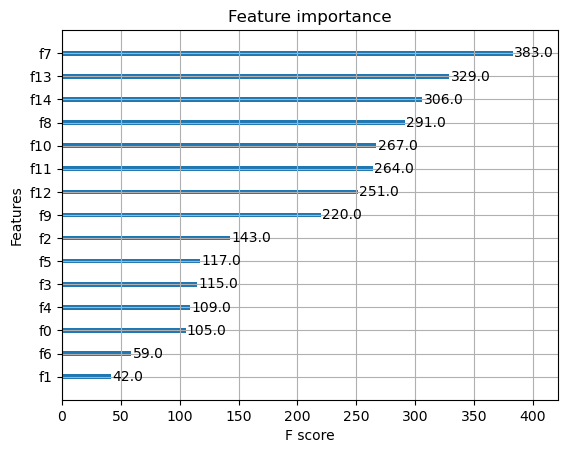

In [412]:
# Measuring feature importance
xgboost1 = opt.best_estimator_.steps[1]
xgboost2 = xgboost1[1]
plot_importance(xgboost2)

In [414]:
# Step 1: Get the regressor
xgboost_model = opt.best_estimator_.named_steps['clf']

# Step 2: Get transformed feature names from the preprocessor
preprocessor = opt.best_estimator_.named_steps['preprocessor']

# Get transformed feature names for each transformer
cat_features = preprocessor.transformers_[0][2]  # list of categorical column names
num_features = preprocessor.transformers_[1][2]  # list of numeric column names

# Combine them (TargetEncoder returns same names; MinMaxScaler does too)
all_features = cat_features + num_features

# Step 3: Extract feature importances
importances = xgboost_model.feature_importances_

# Step 4: Create DataFrame
feat_imp_df = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

display(feat_imp_df)

,feature,importance
3,Couples.Match,0.396850
4,AOA.Sigma,0.128051
8,step2_centered,0.089683
2,Honors.A.This.Specialty,0.060385
5,GHHS,0.048734
6,Required.to.Remediate,0.033419
13,X..Volunteer.Experiences,0.033251
14,X..Leadership.Positions,0.030877
7,step1_centered,0.030275
10,X..Research.Experiences,0.026722


In [416]:
opt.best_params_

OrderedDict([('clf__colsample_bylevel', 1.0),
             ('clf__colsample_bynode', 0.9220708783721945),
             ('clf__colsample_bytree', 0.8016200856392117),
             ('clf__gamma', 8.176189841974143),
             ('clf__learning_rate', 0.07035314336828287),
             ('clf__max_depth', 5),
             ('clf__reg_alpha', 4.2744624394363075),
             ('clf__reg_lambda', 4.0168865767728565),
             ('clf__subsample', 0.7508086818205133)])

In [418]:
best_params = {
    "max_depth": 5,
    "learning_rate": 0.07035314336828287,
    "subsample": 0.7508086818205133,
    "colsample_bytree": 0.8016200856392117,
    "colsample_bylevel": 1.0,
    "colsample_bynode": 0.9220708783721945,
    "reg_alpha": 4.2744624394363075,
    "reg_lambda": 4.0168865767728565,
    "gamma": 8.176189841974143,
    "random_state": 7
}

## **XGBoost on individual degree paths, using the best parameters**

### **MD**

In [424]:
# Filtering for predictor columns
cols_to_keep = ['Public_School', "IvyP", 'step1_centered', 'step2_centered', "X..Honored.Clerkships", "Honors.A.This.Specialty", "AOA.Sigma", 'GHHS', 'Research.Year', 
                'Absence.Year', "Couples.Match", "X..Research.Experiences", "X..Abstracts..Pres..Posters", "X..Peer.Rev.Publications", "X..Volunteer.Experiences", "X..Leadership.Positions", 
                'Required.to.Remediate', "X..Interviews.Attended"]  #"degrees", "reputation_rank_mean" 

# Train test split
df_clean2 = df_clean.set_index("STAR.ID")
df_clean2 = df_clean2[df_clean2["degrees"]=="MD"]
df_clean2 = df_clean2[cols_to_keep]
X = df_clean2.drop(columns="X..Interviews.Attended")
y = df_clean2["X..Interviews.Attended"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [426]:
# Making the pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', XGBRegressor(**best_params))
])
print(pipe)

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                                  ['Public_School', 'IvyP',
                                                   'Honors.A.This.Specialty',
                                                   'Couples.Match', 'AOA.Sigma',
                                                   'GHHS',
                                                   'Required.to.Remediate']),
                                                 ('num', MinMaxScaler(),
                                                  ['step1_centered',
                                                   'step2_centered',
                                                   'X..Honored.Clerkships',
                                                   'X..Research.Experiences',
                                                   'X..Abstracts..Pres..Posters',
                                                   'X..Peer.Rev.Pu...
    

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                                  ['Public_School', 'IvyP',
                                                   'Honors.A.This.Specialty',
                                                   'Couples.Match', 'AOA.Sigma',
                                                   'GHHS',
                                                   'Required.to.Remediate']),
                                                 ('num', MinMaxScaler(),
                                                  ['step1_centered',
                                                   'step2_centered',
                                                   'X..Honored.Clerkships',
                                                   'X..Research.Experiences',
                                                   'X..Abstracts..Pres..Posters',
                                                   'X..Peer.Rev.Pu...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.07035314336828287, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=7, ...))])

In [428]:
# Function to get feature importances dataframe
def feat_importances(model, degree):
    
    # Step 1: Get the regressor
    xgboost_model = model.named_steps['clf']
    
    # Step 2: Get transformed feature names from the preprocessor
    preprocessor = model.named_steps['preprocessor']
    
    # Get transformed feature names for each transformer
    cat_features = preprocessor.transformers_[0][2]  # list of categorical column names
    num_features = preprocessor.transformers_[1][2]  # list of numeric column names
    
    # Combine them (TargetEncoder returns same names; MinMaxScaler does too)
    all_features = cat_features + num_features
    
    # Step 3: Extract feature importances
    importances = xgboost_model.feature_importances_
    
    # Step 4: Create DataFrame
    feat_imp_df = pd.DataFrame({
        'feature': all_features,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    feat_imp_df["degree"] = degree

    # Step 5: returning the dataframe
    return feat_imp_df

In [430]:
feat_md = feat_importances(model=pipe, degree="MD")
feat_md

,feature,importance,degree
3,Couples.Match,0.393549,MD
4,AOA.Sigma,0.120013,MD
8,step2_centered,0.078855,MD
2,Honors.A.This.Specialty,0.062883,MD
5,GHHS,0.046433,MD
13,X..Volunteer.Experiences,0.037431,MD
14,X..Leadership.Positions,0.033040,MD
6,Required.to.Remediate,0.032707,MD
7,step1_centered,0.031144,MD
0,Public_School,0.029770,MD


### **MD-PhD**

In [432]:
# Filtering for predictor columns
cols_to_keep = ['Public_School', "IvyP", 'step1_centered', 'step2_centered', "X..Honored.Clerkships", "Honors.A.This.Specialty", "AOA.Sigma", 'GHHS', 'Research.Year', 
                'Absence.Year', "Couples.Match", "X..Research.Experiences", "X..Abstracts..Pres..Posters", "X..Peer.Rev.Publications", "X..Volunteer.Experiences", "X..Leadership.Positions", 
                'Required.to.Remediate', "X..Interviews.Attended"]  #"degrees", "reputation_rank_mean" 

# Train test split
df_clean2 = df_clean.set_index("STAR.ID")
df_clean2 = df_clean2[df_clean2["degrees"]=="MD-PhD"]
df_clean2 = df_clean2[cols_to_keep]
X = df_clean2.drop(columns="X..Interviews.Attended")
y = df_clean2["X..Interviews.Attended"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [434]:
# Making the pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', XGBRegressor(**best_params))
])
print(pipe)

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                                  ['Public_School', 'IvyP',
                                                   'Honors.A.This.Specialty',
                                                   'Couples.Match', 'AOA.Sigma',
                                                   'GHHS',
                                                   'Required.to.Remediate']),
                                                 ('num', MinMaxScaler(),
                                                  ['step1_centered',
                                                   'step2_centered',
                                                   'X..Honored.Clerkships',
                                                   'X..Research.Experiences',
                                                   'X..Abstracts..Pres..Posters',
                                                   'X..Peer.Rev.Pu...
    

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                                  ['Public_School', 'IvyP',
                                                   'Honors.A.This.Specialty',
                                                   'Couples.Match', 'AOA.Sigma',
                                                   'GHHS',
                                                   'Required.to.Remediate']),
                                                 ('num', MinMaxScaler(),
                                                  ['step1_centered',
                                                   'step2_centered',
                                                   'X..Honored.Clerkships',
                                                   'X..Research.Experiences',
                                                   'X..Abstracts..Pres..Posters',
                                                   'X..Peer.Rev.Pu...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.07035314336828287, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=7, ...))])

In [436]:
feat_mdphd = feat_importances(model=pipe, degree="MD-PhD")
feat_mdphd

,feature,importance,degree
3,Couples.Match,0.121627,MD-PhD
8,step2_centered,0.081117,MD-PhD
13,X..Volunteer.Experiences,0.072553,MD-PhD
7,step1_centered,0.072493,MD-PhD
5,GHHS,0.070914,MD-PhD
2,Honors.A.This.Specialty,0.067548,MD-PhD
14,X..Leadership.Positions,0.066724,MD-PhD
12,X..Peer.Rev.Publications,0.062617,MD-PhD
10,X..Research.Experiences,0.062140,MD-PhD
11,X..Abstracts..Pres..Posters,0.061771,MD-PhD


### **MD-MPH**

In [438]:
# Filtering for predictor columns
cols_to_keep = ['Public_School', "IvyP", 'step1_centered', 'step2_centered', "X..Honored.Clerkships", "Honors.A.This.Specialty", "AOA.Sigma", 'GHHS', 'Research.Year', 
                'Absence.Year', "Couples.Match", "X..Research.Experiences", "X..Abstracts..Pres..Posters", "X..Peer.Rev.Publications", "X..Volunteer.Experiences", "X..Leadership.Positions", 
                'Required.to.Remediate', "X..Interviews.Attended"]  #"degrees", "reputation_rank_mean" 

# Train test split
df_clean2 = df_clean.set_index("STAR.ID")
df_clean2 = df_clean2[df_clean2["degrees"]=="MD-MPH"]
df_clean2 = df_clean2[cols_to_keep]
X = df_clean2.drop(columns="X..Interviews.Attended")
y = df_clean2["X..Interviews.Attended"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [440]:
# Making the pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', XGBRegressor(**best_params))
])
print(pipe)

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                                  ['Public_School', 'IvyP',
                                                   'Honors.A.This.Specialty',
                                                   'Couples.Match', 'AOA.Sigma',
                                                   'GHHS',
                                                   'Required.to.Remediate']),
                                                 ('num', MinMaxScaler(),
                                                  ['step1_centered',
                                                   'step2_centered',
                                                   'X..Honored.Clerkships',
                                                   'X..Research.Experiences',
                                                   'X..Abstracts..Pres..Posters',
                                                   'X..Peer.Rev.Pu...
    

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                                  ['Public_School', 'IvyP',
                                                   'Honors.A.This.Specialty',
                                                   'Couples.Match', 'AOA.Sigma',
                                                   'GHHS',
                                                   'Required.to.Remediate']),
                                                 ('num', MinMaxScaler(),
                                                  ['step1_centered',
                                                   'step2_centered',
                                                   'X..Honored.Clerkships',
                                                   'X..Research.Experiences',
                                                   'X..Abstracts..Pres..Posters',
                                                   'X..Peer.Rev.Pu...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.07035314336828287, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=7, ...))])

In [442]:
feat_mdmph = feat_importances(model=pipe, degree="MD-MPH")
feat_mdmph

,feature,importance,degree
3,Couples.Match,0.211214,MD-MPH
6,Required.to.Remediate,0.094853,MD-MPH
8,step2_centered,0.085830,MD-MPH
4,AOA.Sigma,0.063321,MD-MPH
5,GHHS,0.059590,MD-MPH
11,X..Abstracts..Pres..Posters,0.053504,MD-MPH
2,Honors.A.This.Specialty,0.051654,MD-MPH
10,X..Research.Experiences,0.051382,MD-MPH
7,step1_centered,0.051070,MD-MPH
1,IvyP,0.049390,MD-MPH


### **MD-MBA**

In [444]:
# Filtering for predictor columns
cols_to_keep = ['Public_School', "IvyP", 'step1_centered', 'step2_centered', "X..Honored.Clerkships", "Honors.A.This.Specialty", "AOA.Sigma", 'GHHS', 'Research.Year', 
                'Absence.Year', "Couples.Match", "X..Research.Experiences", "X..Abstracts..Pres..Posters", "X..Peer.Rev.Publications", "X..Volunteer.Experiences", "X..Leadership.Positions", 
                'Required.to.Remediate', "X..Interviews.Attended"]  #"degrees", "reputation_rank_mean" 

# Train test split
df_clean2 = df_clean.set_index("STAR.ID")
df_clean2 = df_clean2[df_clean2["degrees"]=="MD-MBA"]
df_clean2 = df_clean2[cols_to_keep]
X = df_clean2.drop(columns="X..Interviews.Attended")
y = df_clean2["X..Interviews.Attended"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [446]:
# Making the pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', XGBRegressor(**best_params))
])
print(pipe)

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                                  ['Public_School', 'IvyP',
                                                   'Honors.A.This.Specialty',
                                                   'Couples.Match', 'AOA.Sigma',
                                                   'GHHS',
                                                   'Required.to.Remediate']),
                                                 ('num', MinMaxScaler(),
                                                  ['step1_centered',
                                                   'step2_centered',
                                                   'X..Honored.Clerkships',
                                                   'X..Research.Experiences',
                                                   'X..Abstracts..Pres..Posters',
                                                   'X..Peer.Rev.Pu...
    

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                                  ['Public_School', 'IvyP',
                                                   'Honors.A.This.Specialty',
                                                   'Couples.Match', 'AOA.Sigma',
                                                   'GHHS',
                                                   'Required.to.Remediate']),
                                                 ('num', MinMaxScaler(),
                                                  ['step1_centered',
                                                   'step2_centered',
                                                   'X..Honored.Clerkships',
                                                   'X..Research.Experiences',
                                                   'X..Abstracts..Pres..Posters',
                                                   'X..Peer.Rev.Pu...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.07035314336828287, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=7, ...))])

In [448]:
feat_mdmba = feat_importances(model=pipe, degree="MD-MBA")
feat_mdmba

,feature,importance,degree
3,Couples.Match,0.122201,MD-MBA
9,X..Honored.Clerkships,0.091979,MD-MBA
5,GHHS,0.087651,MD-MBA
8,step2_centered,0.077242,MD-MBA
0,Public_School,0.073758,MD-MBA
7,step1_centered,0.070311,MD-MBA
11,X..Abstracts..Pres..Posters,0.069236,MD-MBA
10,X..Research.Experiences,0.063014,MD-MBA
13,X..Volunteer.Experiences,0.061466,MD-MBA
14,X..Leadership.Positions,0.060971,MD-MBA


### **MD-MSc**

In [450]:
# Filtering for predictor columns
cols_to_keep = ['Public_School', "IvyP", 'step1_centered', 'step2_centered', "X..Honored.Clerkships", "Honors.A.This.Specialty", "AOA.Sigma", 'GHHS', 'Research.Year', 
                'Absence.Year', "Couples.Match", "X..Research.Experiences", "X..Abstracts..Pres..Posters", "X..Peer.Rev.Publications", "X..Volunteer.Experiences", "X..Leadership.Positions", 
                'Required.to.Remediate', "X..Interviews.Attended"]  #"degrees", "reputation_rank_mean" 

# Train test split
df_clean2 = df_clean.set_index("STAR.ID")
df_clean2 = df_clean2[df_clean2["degrees"]=="MD-MSc"]
df_clean2 = df_clean2[cols_to_keep]
X = df_clean2.drop(columns="X..Interviews.Attended")
y = df_clean2["X..Interviews.Attended"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [452]:
# Making the pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', XGBRegressor(**best_params))
])
print(pipe)

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                                  ['Public_School', 'IvyP',
                                                   'Honors.A.This.Specialty',
                                                   'Couples.Match', 'AOA.Sigma',
                                                   'GHHS',
                                                   'Required.to.Remediate']),
                                                 ('num', MinMaxScaler(),
                                                  ['step1_centered',
                                                   'step2_centered',
                                                   'X..Honored.Clerkships',
                                                   'X..Research.Experiences',
                                                   'X..Abstracts..Pres..Posters',
                                                   'X..Peer.Rev.Pu...
    

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', TargetEncoder(),
                                                  ['Public_School', 'IvyP',
                                                   'Honors.A.This.Specialty',
                                                   'Couples.Match', 'AOA.Sigma',
                                                   'GHHS',
                                                   'Required.to.Remediate']),
                                                 ('num', MinMaxScaler(),
                                                  ['step1_centered',
                                                   'step2_centered',
                                                   'X..Honored.Clerkships',
                                                   'X..Research.Experiences',
                                                   'X..Abstracts..Pres..Posters',
                                                   'X..Peer.Rev.Pu...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.07035314336828287, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=7, ...))])

In [454]:
feat_mdmsc = feat_importances(model=pipe, degree="MD-MSc")
feat_mdmsc

,feature,importance,degree
3,Couples.Match,0.137557,MD-MSc
4,AOA.Sigma,0.105658,MD-MSc
8,step2_centered,0.090316,MD-MSc
7,step1_centered,0.065118,MD-MSc
5,GHHS,0.062429,MD-MSc
9,X..Honored.Clerkships,0.060790,MD-MSc
14,X..Leadership.Positions,0.059849,MD-MSc
13,X..Volunteer.Experiences,0.058233,MD-MSc
0,Public_School,0.057751,MD-MSc
11,X..Abstracts..Pres..Posters,0.056367,MD-MSc


### **Merging degree paths and exporting**

In [460]:
# Concatenating 
interviews = pd.concat([feat_md, feat_mdphd, feat_mdmph, feat_mdmba, feat_mdmsc], axis=1)
display(interviews)

# Exporting
#interviews.to_excel("tables/XGBoost_interviews.xlsx", index=False)

,feature,importance,degree,feature,importance,degree,feature,importance,degree,feature,importance,degree,feature,importance,degree
3,Couples.Match,0.393549,MD,Couples.Match,0.121627,MD-PhD,Couples.Match,0.211214,MD-MPH,Couples.Match,0.122201,MD-MBA,Couples.Match,0.137557,MD-MSc
4,AOA.Sigma,0.120013,MD,AOA.Sigma,0.057536,MD-PhD,AOA.Sigma,0.063321,MD-MPH,AOA.Sigma,0.036971,MD-MBA,AOA.Sigma,0.105658,MD-MSc
8,step2_centered,0.078855,MD,step2_centered,0.081117,MD-PhD,step2_centered,0.085830,MD-MPH,step2_centered,0.077242,MD-MBA,step2_centered,0.090316,MD-MSc
2,Honors.A.This.Specialty,0.062883,MD,Honors.A.This.Specialty,0.067548,MD-PhD,Honors.A.This.Specialty,0.051654,MD-MPH,Honors.A.This.Specialty,0.050608,MD-MBA,Honors.A.This.Specialty,0.052628,MD-MSc
5,GHHS,0.046433,MD,GHHS,0.070914,MD-PhD,GHHS,0.059590,MD-MPH,GHHS,0.087651,MD-MBA,GHHS,0.062429,MD-MSc
13,X..Volunteer.Experiences,0.037431,MD,X..Volunteer.Experiences,0.072553,MD-PhD,X..Volunteer.Experiences,0.045568,MD-MPH,X..Volunteer.Experiences,0.061466,MD-MBA,X..Volunteer.Experiences,0.058233,MD-MSc
14,X..Leadership.Positions,0.033040,MD,X..Leadership.Positions,0.066724,MD-PhD,X..Leadership.Positions,0.048333,MD-MPH,X..Leadership.Positions,0.060971,MD-MBA,X..Leadership.Positions,0.059849,MD-MSc
6,Required.to.Remediate,0.032707,MD,Required.to.Remediate,0.048682,MD-PhD,Required.to.Remediate,0.094853,MD-MPH,Required.to.Remediate,0.037270,MD-MBA,Required.to.Remediate,0.034158,MD-MSc
7,step1_centered,0.031144,MD,step1_centered,0.072493,MD-PhD,step1_centered,0.051070,MD-MPH,step1_centered,0.070311,MD-MBA,step1_centered,0.065118,MD-MSc
0,Public_School,0.029770,MD,Public_School,0.048693,MD-PhD,Public_School,0.045351,MD-MPH,Public_School,0.073758,MD-MBA,Public_School,0.057751,MD-MSc
